# Imports

In [2]:
import os
# import os
os.environ['TRANSFORMERS_CACHE'] = '/data/cg46773/transformer'
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4" 
from tqdm.notebook import tqdm


In [3]:
from itertools import groupby
import editdistance


In [4]:
# import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as transforms
import argparse
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data.sampler import Sampler, BatchSampler, SubsetRandomSampler
import pickle
import numpy as np
import python_speech_features 
import scipy.io.wavfile as wav


/data/cg46773/miniconda3/envs/base3.7/lib/python3.7/site-packages/torchaudio/_internal/module_utils.py:87: UserWarning: Failed to import soundfile. 'soundfile' backend is not available.
  warnings.warn("Failed to import soundfile. 'soundfile' backend is not available.")


In [5]:
import math

In [6]:
from ast import literal_eval

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch-size', type=int, default=1, metavar='N',
                    help='input batch size for training (default: 10)')
parser.add_argument('--epochs', type=int, default=10, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--no-mps', action='store_true', default=False,
                    help='disables macOS GPU training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=300, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--silence', type=int, default=1, choices=[0,1],metavar='N',
                    help='If silence==1 then _ char is put in begin/end of phm_seq, if ')
parser.add_argument('--hidden_size', type=int, default=10, metavar='N',
                    help='hidden size of the LSTM')
parser.add_argument('--num_layers', type=int, default=1, metavar='N',
                    help='num layers of  LSTM')
parser.add_argument('--lr', type=float, default=1e-3,
                    help='learning rate')
args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()
# args.mps = not args.no_mps and torch.backends.mps.is_available()

if args.cuda:
    device = torch.device("cuda")
elif args.mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")


In [8]:
args.num_layers,args.silence

(1, 1)

# Initialize Locale, Phone, Phoneme, Mapping

In [9]:
allophone_data = pickle.load(
    open("allophone_mappings_new_new.pkl","rb"))

locale_to_id={locale:idx for idx,locale in enumerate(allophone_data['language_locale to (language-local)id to phoneme'].keys())}
id_to_locale={idx:locale for locale,idx in locale_to_id.items()}
# maps locale to len of phonemes
locale_to_num_phonemes={locale:len(allophone_data['language_locale to (language-local)id to phoneme'][locale]) for locale in locale_to_id}
lang_to_phoneme_to_id = allophone_data['language_locale to phoneme to (language-local)id']
universalPhoneme_to_id=allophone_data['universal_phoneme to id']

In [10]:
list(allophone_data.keys())

['id to universal_phone',
 'universal_phone to id',
 'id to universal_phoneme',
 'universal_phoneme to id',
 'language_locale to (language-local)id to phoneme',
 'language_locale to phoneme to (language-local)id',
 '(Allophone mappings) language_locale to (language-local)id to universal_phone_ids',
 'language_locale to (language-local)id to phone',
 'language_locale to phone to (language-local)id',
 'language_locale to phone attributes array',
 '(Allophone mappings) language_locale to (language-local)id to (language-local)ids',
 'language_locale to (language-local)phoneme-id to (universal)phoneme-id']

# Initialize Dataset

In [11]:
#https://pytorch.org/audio/stable/generated/torchaudio.transforms.MFCC.html#torchaudio.transforms.MFCC
# def MFCC(filename="sample.wav"):
def MFCC(filename="output1.wav"):
    waveform, sample_rate = torchaudio.load(filename, normalize=True)
    transform = transforms.MFCC(
        sample_rate=sample_rate,
        n_mfcc=40,
        #https://pytorch.org/audio/stable/generated/torchaudio.transforms.MelSpectrogram.html#torchaudio.transforms.MelSpectrogram
        melkwargs={"n_fft": 400, #"hop_length": 160,
                   "n_mels": 40, "center": False}
                  # "win_length": 0.025},
    )
    mfcc = transform(waveform)
    return mfcc

In [12]:
import scipy.signal

In [13]:
(rate,sig) = wav.read('data/hin/audio/hin-008-001.wav')
# mfcc = torch.Tensor(
# print(len(sig))
signal_resampled=scipy.signal.resample(sig,(len(sig)*16000)//rate)
# python_speech_features.mfcc(signal_resampled,16000,numcep=40, nfilt=80)
# )


In [14]:
args.silence=1
args.silence

1

In [15]:
# args.model_name="Allosrs"
args.model_name="Heirarch"
# args.model_name="Shared-ours"
# args.model_name="Shared-theirs"


In [16]:
class MozillaDataset(Dataset):
    def __init__(self, args, csv_file, type_,pt_file,audio_dir,langs_to_choose=None,silence=True):
        data = pd.read_csv(csv_file,keep_default_na=False, na_values=[''])
        if langs_to_choose is not None:
            data=data[data["langcode"].isin(langs_to_choose)].reset_index(drop=True)
        data=data[data["type"]==type_].reset_index(drop=True)
        self.length = len(data)
        audio_paths=audio_dir + '/' + data["path"]
        if not data["path"].iloc[0].endswith(".wav"):
            audio_paths=audio_paths + ".wav"
        self.x_mfcc = []
        #JORDI-- torch-mfcc computation\n",
        # for audio_path in audio_paths:
        #     mfcc = MFCC(audio_path)
        #     #so that the final dim is: 1 x time x n_mfcc\n",
        #     mfcc = mfcc.permute(0,2,1)
        #     mfcc = torch.squeeze(mfcc)
        #     self.x_mfcc.append(mfcc)
        
        #Chitrank-- via python-speech-features",
        want_to_load_from_pt_file=True
        # want_to_load_from_pt_file=False
        if want_to_load_from_pt_file==True:
            self.x_mfcc=torch.load(pt_file)
        else:    
            for audio_path in tqdm(audio_paths):
                (rate,sig) = wav.read(audio_path)
                if rate>16000:
                    sig=scipy.signal.resample(sig,(len(sig)*16000)//rate)
                    rate=16000
                mfcc = torch.Tensor(python_speech_features.mfcc(sig,rate,numcep=40, nfilt=80))
                # mfcc size is already T x F(=40)
                self.x_mfcc.append(mfcc)
            torch.save(self.x_mfcc,f=pt_file)
        

        self.lang = [locale_to_id[i] for i in data["langcode"].values]
        self.start_pos_data = [0]
        for idx in range(1,len(self.lang)):
            if self.lang[idx] != self.lang[idx-1]:
                # append when the language changes 
                self.start_pos_data.append(idx)

        if args.silence==1:
            if silence:
                phm_seq_raw = [['<SIL>']+literal_eval(i)+['<SIL>'] for i in data["phoneme_sequence"].values]
            else:
                phm_seq_raw = [literal_eval(i) for i in data["phoneme_sequence"].values]
        else:
            phm_seq_raw = [literal_eval(i) for i in data["phoneme_sequence"].values]
        if args.model_name=="Shared-theirs":
            self.shared_theirs=True
            phm_seq_raw= [ torch.Tensor([universalPhoneme_to_id[phm] if phm in universalPhoneme_to_id else universalPhoneme_to_id["a"] for phm in phm_seq ])
                          for idx,phm_seq in enumerate(phm_seq_raw)]
        else:
            phm_seq_raw= [ torch.Tensor([lang_to_phoneme_to_id[id_to_locale[self.lang[idx]]][phm] for phm in phm_seq])
                          for idx,phm_seq in enumerate(phm_seq_raw)]
        # self.raw = phm_seq_raw

        self.phm_seq=phm_seq_raw
#         for i in range(self.length):
#             sequence_ = []
#             lang_ = self.lang[i]
#
#             # some phonemes occupies two character space, we have to account for that
#             j = 0
#             special_phm = ["ɕ"]
#             while j < len(phm_seq_raw[i]):
#                 phm = phm_seq_raw[i][j]
#                 if phm == "ɕ" and lang_ == "ru":
#                     sequence_.append(lang_to_phoneme_to_id[lang_]["ɕː"])
#                     j += 2
#                 elif j < len(phm_seq_raw[i]) - 1 and phm_seq_raw[i][j+1] not in lang_to_phoneme_to_id[lang_] and phm_seq_raw[i][j+1] not in special_phm:
#                     next_phm = phm_seq_raw[i][j+1]
#                     new_phm = phm + next_phm
#                     sequence_.append(lang_to_phoneme_to_id[lang_][new_phm])
#                     j += 2
#                 else:
#                     sequence_.append(lang_to_phoneme_to_id[lang_][phm])
#                     j += 1
#             self.phm_seq.append(torch.Tensor(sequence_))
        #self.phm_seq = torch.Tensor(self.phm_seq)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return {"x_mfcc": self.x_mfcc[idx], "lang": self.lang[idx], "phm_seq": self.phm_seq[idx],}
                # "raw":self.raw[idx]}

# mozilla_dataset_train = MozillaDataset(args,csv_file='validated_1000.csv',
mozilla_dataset_train = MozillaDataset(args,csv_file='validated_100.csv',
                                       type_="train",
                                       # pt_file="train_x_mfcc_1000.pt",
                                       pt_file="train_x_mfcc_100.pt",
                                       audio_dir='mozilla/wav_1000_100_1000/')
# mozilla_dataset_dev = MozillaDataset(args,csv_file='validated_1000.csv',
mozilla_dataset_dev = MozillaDataset(args,csv_file='validated_100.csv',
                                     type_="dev",
                                     # pt_file="dev_x_mfcc_1000.pt",
                                     pt_file="dev_x_mfcc_100.pt",
                                     audio_dir='mozilla/wav_1000_100_1000/')
training_languages=set({"vi":"vie","tr":"tur","en":"eng",
                        "de":"deu","es":"spa","it":"ita",
                        "ja":"jpn","ru":"rus","zh-CN":"cmn"}.values())
non_trainining_languages=set(locale_to_id.keys())-training_languages
# mozilla_dataset_test = MozillaDataset(args,csv_file='validated_1000.csv',
mozilla_dataset_test_trainingLangs = MozillaDataset(args,csv_file='validated_100_test1000.csv',
                                      type_="test",
                                      # pt_file="test_trainingLang_x_mfcc_1000.pt",
                                      pt_file="test_trainingLang_x_mfcc_100.pt",
                                      audio_dir='mozilla/wav_1000_100_1000/',
                                     langs_to_choose=training_languages)
# mozilla_dataset_test = MozillaDataset(args,csv_file='validated_1000.csv',
mozilla_dataset_test_nonTrainingLangs = MozillaDataset(args,csv_file='validated_100_test1000.csv',
                                      type_="test",
                                      # pt_file="test_nonTrainingLang_x_mfcc_1000.pt",
                                      pt_file="test_nonTrainingLang_x_mfcc_100.pt",
                                      audio_dir='mozilla/wav_1000_100_1000/',
                                     langs_to_choose=non_trainining_languages)
ucla_dataset_test = MozillaDataset(args,csv_file='ucla_utterances.csv',
                                      type_="test",
                                      pt_file="ucla_test_x_mfcc.pt",
                                      audio_dir='data/',
                                   silence=False,)
# print("length of dataset: ", len(mozilla_dataset))

In [17]:
len(mozilla_dataset_test_nonTrainingLangs)

10000

In [18]:
def collate_fn(batch):
    # print("printing all the raw phonemes in every batch: ")
    # for d in batch:
    #     print(d["raw"])
    x_mfcc_list = [d['x_mfcc'] for d in batch]
    # print("shape of first in x_mfcc_list", x_mfcc_list[0].shape)
    # print("shape of first in x_mfcc_list", x_mfcc_list[1].shape)
    # print("shape of first in x_mfcc_list", x_mfcc_list[2].shape)
    # print("shape of first in x_mfcc_list", x_mfcc_list[3].shape)
    x_mfcc_tensor = pad_sequence(x_mfcc_list, batch_first=True, padding_value=0)
    #x_mfcc_lengths = sorted([len(x) for x in x_mfcc_list], reverse=True)
    x_mfcc_lengths = [len(x) for x in x_mfcc_list]
    #print("x_mfcc_lengths: ", x_mfcc_lengths)
    x_mfcc_tensor = pack_padded_sequence(x_mfcc_tensor, lengths= x_mfcc_lengths, batch_first=True, enforce_sorted = False)
    lang_list = [d['lang'] for d in batch]
    #lang_list = torch.tensor(lang_list)
    phm_seq_list = [d['phm_seq'] for d in batch]
    #print("phm_seq_list", phm_seq_list)
    phm_seq_tensor = pad_sequence(phm_seq_list, batch_first=True, padding_value=0).to(int)
    phm_seq_lengths = [len(x) for x in phm_seq_list]
    # print("phm_seq_lengths: ", phm_seq_lengths)
    #phm_seq_pack_padded_sequence = pack_padded_sequence(phm_seq_tensor, lengths= phm_seq_lengths, batch_first=True, enforce_sorted = False)
    # print("packed padded sequence: ", x_mfcc_tensor)
    return {
        "x_mfcc": x_mfcc_tensor, # packed padded tensor
        "lang": lang_list, # python list
        "phm_seq": phm_seq_tensor, # padded tensor
        "x_mfcc_lengths": torch.Tensor(x_mfcc_lengths).to(int), # sorted in decreasing order
        "phm_seq_lengths": torch.Tensor(phm_seq_lengths).to(int) # sorted in decreasing order
    }

In [19]:
class BucketSampler(Sampler):
    '''
        creates a bucket sampler where we sample randomly from the same language without replacement
    '''
    def __init__(self, dataset, batch_size, generator=None) -> None:
        self.dataset = dataset
        self.batch_size = batch_size
        self.generator = generator
        start_pos_data = self.dataset.start_pos_data
        start_end_indices = []
        for i in range(len(start_pos_data) - 1):
            start_end_indices.append((start_pos_data[i], start_pos_data[i+1]))
        start_end_indices.append((start_pos_data[-1], len(self.dataset)))
        ranges  = [range(start, end) for start, end in start_end_indices]
        subset_samplers = [SubsetRandomSampler(range_, generator=generator) for range_ in ranges]
        self.samplers = [
            BatchSampler(subset_sampler, batch_size, drop_last=False) for subset_sampler in subset_samplers
        ]
        self._len = 0
        for sampler in self.samplers:
            self._len += len(sampler)
        
    def __iter__(self):
        iterators = [iter(sampler) for sampler in self.samplers]
        while iterators:
            randint = torch.randint(0, len(iterators),size=(1,), generator=self.generator)[0]
            try:
                yield next(iterators[randint])
            except StopIteration:
                iterators.pop(randint)
    def __len__(self):
        return self._len
bucketSampler = BucketSampler(mozilla_dataset_train, batch_size = 4)
dataloader = DataLoader(mozilla_dataset_train, batch_sampler = bucketSampler, collate_fn=collate_fn)#, num_workers=4)
for i in dataloader:
    # print("mfcc: ", i["x_mfcc"].data.shape)
    # print("language: ",i["lang"])
    # print("phm_seq: ", i["phm_seq"])
    break

# Allosaurus / Heirarchical

In [20]:
device,args.hidden_size

(device(type='cuda'), 10)

In [21]:
'''
    This cell initializes the signature matrix
'''
if args.model_name=="Allosrs":
    num_universal_phones=len(allophone_data["universal_phone to id"])
    locale_to_allophone_mappings_id = allophone_data['(Allophone mappings) language_locale to (language-local)id to universal_phone_ids']
    #locale_to_allophone_mappings_array = {loc:np.zeros((locale_to_num_phonemes[loc], num_universal_phones)) for loc in locale_to_id}
    signature_matrix = {loc:np.zeros((locale_to_num_phonemes[loc], num_universal_phones)) for loc in locale_to_id}

    for lang in signature_matrix:
        # print(locale_to_allophone_mappings_id[lang])
        for q, phones in locale_to_allophone_mappings_id[lang].items():
            for p in phones:
                # q (Phoneme) x P (phone)
                signature_matrix[lang][q, p] = 1
elif args.model_name=="Heirarch":
    num_universal_phones=len(allophone_data["universal_phone to id"])
    lang_to_phone_to_ids=allophone_data['language_locale to phone to (language-local)id']
    lang_to_ids_to_phone=allophone_data['language_locale to (language-local)id to phone']
    lang_to_phoneId_to_attrib_array={locale_to_id[lang]:torch.nn.functional.normalize(torch.Tensor(v).to(device),p=1.0) for lang,v in allophone_data["language_locale to phone attributes array"].items()}
    num_attrs=lang_to_phoneId_to_attrib_array[locale_to_id["eng"]].shape[1]
    locale_to_allophone_mappings_localIds = allophone_data['(Allophone mappings) language_locale to (language-local)id to (language-local)ids']
    
    #locale_to_allophone_mappings_array = {loc:np.zeros((locale_to_num_phonemes[loc], num_universal_phones)) for loc in locale_to_id}
    locale_to_num_phones={locale:len(allophone_data['language_locale to (language-local)id to phone'][locale]) for locale in locale_to_id}
    signature_matrix = {loc:np.zeros((locale_to_num_phonemes[loc], locale_to_num_phones[loc])) for loc in locale_to_id}

    for lang in signature_matrix:
        # print(locale_to_allophone_mappings_id[lang])
        for q, phones in locale_to_allophone_mappings_localIds[lang].items():
            for p in phones:
                # q (Phoneme) x P (phone)
                signature_matrix[lang][q, p] = 1
    
elif args.model_name=="Shared-ours":
    locale_to_phonemelocalIds_to_phonemeUniversalIDs = allophone_data['language_locale to (language-local)phoneme-id to (universal)phoneme-id']
    num_universal_phonemes=len(allophone_data["universal_phoneme to id"])
    locale_to_num_phones={locale:len(allophone_data['language_locale to (language-local)id to phone'][locale]) for locale in locale_to_id}
    signature_matrix = {loc:np.zeros((locale_to_num_phonemes[loc], num_universal_phonemes)) for loc in locale_to_id}

    for lang in signature_matrix:
        for phoneme_local, phoneme_universal in locale_to_phonemelocalIds_to_phonemeUniversalIDs[lang].items():
            signature_matrix[lang][phoneme_local, phoneme_universal] = 1
elif args.model_name=="Shared-theirs":
    num_universal_phonemes=len(allophone_data["universal_phoneme to id"])
    signature_matrix = {loc:np.eye(num_universal_phonemes) for loc in locale_to_id}
else:
    print("!!!Model name INVALID!!!")
    assert 1==0

In [22]:
# allophone_data["language_locale to (language-local)id to phone"]["eng"]
lang_to_phoneme_to_id["hin"]

{'_': 0,
 '<SIL>': 1,
 'b': 2,
 'd̠ʒ': 3,
 'd̻': 4,
 'eː': 5,
 'ẽː': 6,
 'f': 7,
 'iː': 8,
 'ĩː': 9,
 'j': 10,
 'k': 11,
 'kʰ': 12,
 'l̻': 13,
 'm': 14,
 'n̻': 15,
 'oː': 16,
 'õː': 17,
 'p': 18,
 'pʰ': 19,
 'r': 20,
 's': 21,
 't̠ʃ': 22,
 't̠ʃʰ': 23,
 't̻': 24,
 'uː': 25,
 'ũː': 26,
 'z': 27,
 'æ': 28,
 'ɔː': 29,
 'ɔ̃ː': 30,
 'ɖ': 31,
 'ə': 32,
 'ə̃': 33,
 'ɛː': 34,
 'ɛ̃ː': 35,
 'ɡ': 36,
 'ɦ': 37,
 'ɪ': 38,
 'ɪ̃': 39,
 'ɽ': 40,
 'ʂ': 41,
 'ʃ': 42,
 'ʈ': 43,
 'ʈʰ': 44,
 'ʊ': 45,
 'ʊ̃': 46,
 'ʋ': 47}

In [23]:
args.model_name

'Heirarch'

In [24]:
def edit_distance(prediction, target_np_array, prediction_lengths, target_lengths):
    '''
    Computes the SUM of the PER per batch
    '''
    pe_list=[]
    for i in range(len(target_lengths)):
        # get all the trailing zeros out
        target_list = target_np_array[i, :target_lengths[i]].tolist()
        logit = prediction[i][:prediction_lengths[i]]
        # get the corresponding phoneme with the highest probability
        raw_token = [x[0] for x in groupby(np.argmax(logit, axis=1))]
        # get rid of the empty token
        decoded_token = list(filter(lambda a: a != 0, raw_token))

        target_list = list(filter(lambda a: a != 0, target_list))
        pe_list.append(editdistance.distance(target_list, decoded_token))
        
    return pe_list

In [25]:
# scores=[]
class Allosaurus(nn.Module):
    def __init__(self, args):
        '''
            signature_matrix: {lang (str): Mi x N}; locale_to_allophone_mappings_array
        '''
        super().__init__()
        self.name=args.model_name
        self.train_sigmatrix=args.train_sigmatrix
        self.alpha=args.alpha
  
        self.encoder=Encoder(n_layers=args.num_layers,hidden_dim=args.hidden_size,input_size=40) # In short lstm has (n_lay, h, #mfcc) 
        if self.name == "Allosrs":
            self.num_universal_phones = num_universal_phones
            self.phone_distribution_transf_matrix=nn.Linear(2 * args.hidden_size, self.num_universal_phones,bias=False) # It's a (h x N) transformation matrix 
        elif self.name == "Heirarch":
            self.num_universal_phones = num_universal_phones
            final_phone_emb_size=2*args.hidden_size
            self.attr_embeds=torch.nn.Linear(num_attrs, final_phone_emb_size,bias=False) # It's a (A x 2*H) embeddings matrix 
        elif self.name=="Shared-ours" or self.name=="Shared-theirs":
            self.num_universal_phonemes = num_universal_phonemes
            self.get_phoneme_distribution = nn.Linear(2 * args.hidden_size, self.num_universal_phonemes)
        else:
            print("!!! Invald Model name")
            assert 1==0
        
        self.allosaurus_layer_matrix = torch.nn.ParameterList([None]*len(id_to_locale))
        self.allosaurus_layer_matrix_orig = {}
        for lang_id in id_to_locale:
            # every such matrix is of shape (M_i x N)
            locale_=id_to_locale[lang_id]
            if self.name=="Allosrs" or self.name=="Heirarch":
                self.allosaurus_layer_matrix[lang_id]=torch.nn.Parameter(torch.Tensor(signature_matrix[locale_]).to(device),requires_grad=self.train_sigmatrix)
                self.allosaurus_layer_matrix_orig[lang_id]=torch.nn.Parameter(torch.Tensor(signature_matrix[locale_]).to(device),requires_grad=False)
            else:
                self.allosaurus_layer_matrix[lang_id]=torch.nn.Parameter(torch.Tensor(signature_matrix[locale_]).to(device),requires_grad=False)
        self.dropout=torch.nn.Dropout(p=0.33)
        self.relu=torch.nn.ReLU()
        self.unique_values=[5]*10
        self.curr_idx=0
        self.loss_fn = torch.nn.CTCLoss(blank = 0, reduction='mean', zero_infinity=True)
    def compute_phoneme_distribution(self, phone_distrib,lang_id):
        # phone_distrib-- ( B x T x N), 
        # lang-- language index
        # retrieve sign_matrix-- (M_i x N)
        # global scores
        temp=self.allosaurus_layer_matrix[lang_id]*(phone_distrib.unsqueeze(2))
        phoneme_phone_distrib = torch.amax(temp,dim=-1)
        # scores.append(temp[0,170:200,:].detach().cpu())
        # print("Final phoneme_phone_distrib matrix(B x T x phonemes):", phoneme_phone_distrib.shape)
        return torch.nn.functional.log_softmax(phoneme_phone_distrib, dim=-1)
    
    def forward(self, X_mfcc, lang_id,phone_attrs=None):
        '''
            frames is (B x T x F) matrix where 
            B --- batch_size
            T --- time_dimension 
            F --- numFeatures in every unit time (=40) 
            Langs ---(B) matrix that tell us which lang_index does each batch_elemnet corresponds to.
            phone_attrs --- (Phm x A)             
        '''
        packed_padded_sequence_output, (h_n, c_n) = self.encoder(X_mfcc) # returns (B x T x h)
        seq_unpacked, lens_unpacked = pad_packed_sequence(packed_padded_sequence_output, batch_first=True)
        # the hidden space is times 2 because it is bidirectional
        # print("shape of padded sequence in hidden space (Batch x Time x (hidden x2 because bi directional)): ", seq_unpacked.shape, flush=True)
        # print("lens_unpacked: ", lens_unpacked, flush=True)
        # returns (B x T x N)
        if self.name=="Allosrs":
            # phone_distribution = self.dropout(self.phone_distribution_transf_matrix(seq_unpacked))  
            phone_distribution = self.phone_distribution_transf_matrix(seq_unpacked)
            # print("shape of phone_distribution (Batch x Time x num_universal_phones): ",phone_distribution.shape ,flush=True)
        elif self.name=="Heirarch":
            phone_embeds = self.attr_embeds(lang_to_phoneId_to_attrib_array[lang_id])  # output-- (Phm x 2*H)
            # print("shape of phone_distribution (Batch x Time x num_universal_phones): ",phone_distribution.shape ,flush=True)
            phone_distribution = seq_unpacked@(phone_embeds.T)
        elif self.name=="Shared-ours" or self.name=="Shared-theirs":
            # Shared-ours -- improved baseline; Shared-theirs -- dummy baseline
            # the below is actually a phoneme distribution
            phone_distribution = self.get_phoneme_distribution(seq_unpacked)
        # phone_distribution[:,:,0]=-10
        phone_distribution[:,:,0]=0.0
        phone_distribution=self.relu(phone_distribution)
        # print("PHONE",torch.argmax(phone_distribution[0,170:200,:],dim=-1))

        phoneme_distribution = self.compute_phoneme_distribution(phone_distribution, lang_id)
        # print("PHONEME",torch.argmax(phoneme_distribution[0,170:200,:],dim=-1))
        self.unique_values[self.curr_idx]=len(torch.unique(torch.argmax(phoneme_distribution.detach(),dim=-1), sorted=False, return_inverse=False))
        self.curr_idx=(self.curr_idx+1)%10
        if max(self.unique_values)<3: 
            stop_training=False
        else:
            stop_training=False
            
        # print("shape of phoneme after amax (Batch x Time x ?): ",phoneme_distrib.shape ,flush=True)
        #[compute_phoneme_distribution(allosaurus_layer_matrix[i],langs[i])
         #                for i in range(len(langs))] # (return )
            
        return phoneme_distribution,stop_training
             
        
    def loss(self, y_ref, y_scores, src_length, tgt_length, lang_id,mess="train"):
        # y_ref is of shape (B x T_o) where T_o= time_stamps in output space. 
        # y_predicted is of shape [T_inp x M_o_1, T_inp x M_o_2, ..., T_inp x M_o_B] where B is the Batch_size
        #   where T_i= time_stamps in input space. Note T_o!=T_i 

        # ctc_loss= torch.mean([self.loss_fn(y_scores[i], y_ref[i]) for i in range(len(y_ref))])
        ctc_loss= torch.mean(self.loss_fn(y_scores.transpose(0,1), y_ref, src_length, tgt_length))
        # return ctc_loss+alpha*torch.mean([torc.norm((allosaurus_layer_matrix[i]-signature_matrix[i])) 
        #                    for i in range(len(languages_in_current_batch))])
        # print(src_length[:5],tgt_length[:5])
        if self.name=="Allosrs" or self.name=="Heirarch":
            weights = self.allosaurus_layer_matrix[lang_id]
            weights_orig = self.allosaurus_layer_matrix_orig[lang_id]
            b=self.alpha * torch.square(torch.linalg.matrix_norm((weights-weights_orig)+1e-8))
        else:
            b=0
        if mess=="test":
            y_scores_np_array = y_scores.cpu().detach().numpy()
            y_ref_np_array = y_ref.cpu().detach().numpy()
            src_length_np_array = src_length.cpu().detach().numpy()
            tgt_length_np_array = tgt_length.cpu().detach().numpy()
            phoneme_error_list = edit_distance(y_scores_np_array, y_ref_np_array, src_length_np_array, tgt_length_np_array)
            # phoneme_count = sum(tgt_length)
            return ctc_loss,b,phoneme_error_list
        else:
            # print("ctc_loss",ctc_loss)
            return ctc_loss,b, None
        
class Encoder(nn.Module):
    # def __init__(self, n_layers=6,hidden_dim=1024,input_size=40):
    def __init__(self, n_layers=1,hidden_dim=10,input_size=40):
        super().__init__()

        self.bi_LSTM=torch.nn.LSTM(input_size=input_size,num_layers=n_layers,
                         hidden_size=hidden_dim,batch_first=True,
                            bidirectional=True)
    def forward(self, x):
        # x is (B x T x F=40), output (B x T x lstm_hidden_size)
        return self.bi_LSTM(x)
args.batch_size=64

args.num_layers=6
# args.num_layers=4
# args.num_layers=2

# args.hidden_size=512
# args.hidden_size=256
args.hidden_size=64

args.alpha=10
# args.alpha=1
# args.alpha=0.1

args.lr=1e-3

args.train_sigmatrix=True

universal_phone_num = len(allophone_data['id to universal_phone'])
model = Allosaurus(args).to(device)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
# optimizer = optim.SGD(model.parameters(), lr=args.lr)
torch.autograd.set_detect_anomaly(True)

In [26]:
# for k in model.named_parameters():
    # print(k[0])

In [27]:
torch.unique(torch.tensor([[1, 3], [2, 3]], dtype=torch.long), sorted=False, return_inverse=False)

tensor([2, 3, 1])

In [28]:
torch.Tensor([[1,2,3],[4,5,6]]).T

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

In [29]:
model.encoder.bi_LSTM.num_layers,model.encoder.bi_LSTM.hidden_size

(6, 64)

In [30]:
model.name

'Heirarch'

In [31]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, log_file,patience=7, verbose=False, delta=0, path='allosrs/model/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        self.log_file=log_file
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            with open(self.log_file,mode="a") as wfile:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}\n',file=wfile)
            self.trace_func(f'{bcolors.FAIL}EarlyStopping counter: {self.counter} out of {self.patience}{bcolors.ENDC}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            with open(self.log_file,mode="a") as wfile:
                print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n',file=wfile)
            
            self.trace_func(f'{bcolors.OKGREEN}Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...{bcolors.ENDC}\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [32]:
#TODO: 1. write the validation loss loop while using the new data csv file -- change locale to language
#TODO: 2. early stopping
#TODO: 3. Phoneme error 

In [33]:
def train(epoch,dl,log_file):
# training loop
    model.train()
    train_loss = 0
    # "x_mfcc": x_mfcc_tensor, # packed padded sequence
    # "lang": lang_list, # python list
    # "phm_seq": phm_seq_tensor, # packed padded tensor
    # "x_mfcc_lengths": x_mfcc_lengths, # sorted in decreasing order
    # "phm_seq_lengths": phm_seq_lengths # sorted in decreasing order
    batch_idx=0
    predictions=[]
    for data in tqdm(dl):
        # break
        batch_idx+=1
        #X_mfcc = data["x_mfcc"].to(device)
        X_mfcc = data["x_mfcc"]
        lang = data["lang"]
        if model.name == "shared":
            phm_seq = data["phm_seq_universal"]
        else:
            phm_seq = data["phm_seq"]
        # phm_seq = data["phm_seq"]
        x_mfcc_lengths = data["x_mfcc_lengths"]
        phm_seq_lengths = data["phm_seq_lengths"]
        batch_size=len(lang)

        optimizer.zero_grad()
        # print("the language of this batch is: ", lang[0], flush=True)
        # print("batch_idx", batch_idx, flush=True)
        # we are assuming one language per batch here
        y_predicted,signal = model(X_mfcc.to(device), lang[0])
        if signal==True: 
            return 0,True
        loss_a,loss_b,_ = model.loss(phm_seq.to(device), y_predicted, x_mfcc_lengths.to(device), phm_seq_lengths.to(device), lang[0])
        loss=loss_a+loss_b
        loss.backward()
        optimizer.step()
        train_loss += batch_size*loss_a.detach().cpu().item()
        if batch_idx % args.log_interval == 0:
            # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #     epoch, batch_idx * len(lang), len(train_loader.dataset),
            #     100. * batch_idx / len(train_loader),
            #     loss.item() / len(data)))
            print('\t\tTrain Epoch: {} iter:{} \t CTC Loss: {:.6f}'.format(
                epoch, batch_idx,loss_a.item() / len(data)))
            with open(log_file,mode="a") as wfile:
                print('\t\tTrain Epoch: {} iter:{} \t CTC Loss: {:.6f}'.format(
                    epoch, batch_idx,loss_a.item() / len(data)),file=wfile)
    if epoch%1==0:
        print('Train Epoch: {} ====> Average CTC loss: {:.4f}'.format(
          epoch, train_loss / len(dl.dataset)))
        with open(log_file,mode="a") as wfile:
            print('Train Epoch: {} ====> Average CTC loss: {:.4f}'.format(
              epoch, train_loss / len(dl.dataset)),file=wfile)
            
    return train_loss,False

In [34]:
1e-8*3

3.0000000000000004e-08

In [35]:
# test_loader = DataLoader(mozilla_dataset, batch_sampler = bucketSampler, collate_fn=collate_fn)
def evaluate(epoch,dl,log_file,mess="val"):
    model.eval()
    test_loss = 0
    phoneme_error_info = {}
    phoneme_count_info = {}
    overall_per=0
    overall_size=0
    with torch.no_grad():
        for data in tqdm(dl):
            # break
            X_mfcc = data["x_mfcc"]
            # print(X_mfcc.data.shape)
            lang = data["lang"]
            if model.name == "shared":
                phm_seq = data["phm_seq_universal"]
            else:
                phm_seq = data["phm_seq"]
            # phm_seq = data["phm_seq"]
            x_mfcc_lengths = data["x_mfcc_lengths"]
            phm_seq_lengths = data["phm_seq_lengths"]
            batch_size=len(lang)
            y_predicted,_ = model(X_mfcc.to(device), lang[0])
            loss_a,loss_b, pe_list = model.loss(phm_seq.to(device), y_predicted, 
                                                x_mfcc_lengths.to(device), 
                                                phm_seq_lengths.to(device), 
                                                lang[0],
                                                mess=mess)
            if mess=="test":
                # print("doing PER comp")
                langcode=id_to_locale[lang[0]]
                if args.silence==1:
                    temp=phm_seq_lengths-2
                else: 
                    temp=phm_seq_lengths
                len_normalized_pe_list=torch.Tensor(pe_list)/temp
                overall_per+=sum(pe_list)
                overall_size+=len(pe_list)
                if langcode not in phoneme_error_info: 
                    phoneme_error_info[langcode]={}
                    phoneme_count_info[langcode]={}
                for idx,len_ in enumerate(temp.tolist()):
                    if len_ not in phoneme_error_info[langcode]: 
                        phoneme_error_info[langcode][len_]=0
                        phoneme_count_info[langcode][len_]=0
                    phoneme_error_info[langcode][len_]+=len_normalized_pe_list[idx]
                    phoneme_count_info[langcode][len_]+=1
            test_loss += batch_size*loss_a.detach().cpu().item()
    test_loss /= len(dl.dataset)
    with open(log_file,mode="a") as wfile:
        print('Validation/Test Epoch {}====> average CTC loss: {:.4f}'.format(epoch,test_loss),file=wfile)
    print('Validation/Test Epoch {}====> average CTC loss: {:.4f}'.format(epoch,test_loss))
    if mess=="test":
        for lang in phoneme_error_info:
            for len_ in phoneme_error_info[lang]:
                phoneme_error_info[lang][len_]=phoneme_error_info[lang][len_]/phoneme_count_info[lang][len_]
        overall_per=overall_per/overall_size
        with open(log_file,mode="a") as wfile:
            print('Test Epoch {}====> PER : {:.4f}'.format(epoch,overall_per),file=wfile)
        print('Test Epoch {}====> PER : {:.4f}'.format(epoch,overall_per))
    return test_loss,phoneme_error_info,overall_per

In [36]:
model.allosaurus_layer_matrix[locale_to_id["eng"]].shape

torch.Size([40, 49])

In [37]:
torch.nn.functional.log_softmax(torch.Tensor([1,2]),dim=0)

tensor([-1.3133, -0.3133])

In [ ]:
args.batch_size=16
args.epochs=1000
bucketSampler_train = BucketSampler(mozilla_dataset_train, batch_size = args.batch_size)
bucketSampler_dev = BucketSampler(mozilla_dataset_dev, batch_size = 20)
bucketSampler_test_trainingLang = BucketSampler(mozilla_dataset_test_trainingLangs, batch_size = 20)
bucketSampler_test_noTrainingLang = BucketSampler(mozilla_dataset_test_nonTrainingLangs, batch_size = 20)
bucketSampler_ucla_test = BucketSampler(ucla_dataset_test, batch_size = 20)

train_dataloader = DataLoader(mozilla_dataset_train, batch_sampler = bucketSampler_train, collate_fn=collate_fn)#, num_workers=4)
dev_dataloader = DataLoader(mozilla_dataset_dev, batch_sampler = bucketSampler_dev, collate_fn=collate_fn)#, num_workers=4)
test_dataloader_trainingLang = DataLoader(mozilla_dataset_test_trainingLangs, batch_sampler = bucketSampler_test_trainingLang, collate_fn=collate_fn)#, num_workers=4)
test_dataloader_nonTrainingLang = DataLoader(mozilla_dataset_test_nonTrainingLangs, batch_sampler = bucketSampler_test_noTrainingLang, collate_fn=collate_fn)#, num_workers=4)
ucla_test_dataloader = DataLoader(ucla_dataset_test, batch_sampler = bucketSampler_ucla_test, collate_fn=collate_fn)#, num_workers=4)

basefilename=f"newnew_relu_adamw_{args.model_name}_nl{model.encoder.bi_LSTM.num_layers}_hd{model.encoder.bi_LSTM.hidden_size}_lr{args.lr}_bs{args.batch_size}_trainSig{args.train_sigmatrix}"
print("MODEL SAVE NAME---",basefilename)

model_filename=f"allosrs/model/{basefilename}.pt"
# model_filename=f"allosrs/model/dummy-allo-dummy-withper-relu-adamw.pt"

log_filename=f"allosrs/log/{basefilename}.log"
# log_filename=f"allosrs/log/dummy-allo-dummy-withper-relu-adamw.log"
with open(log_filename,mode="w") as wfile:
    print("",end="",file=wfile)

# _,pe_info_test_tl,overall_per_test_tl=evaluate(1-1,test_dataloader_trainingLang,log_filename,mess="test")
# _,pe_info_test_ntl,overall_per_test_ntl=evaluate(1-1,test_dataloader_nonTrainingLang,log_filename,mess="test")
# _,pe_info_test_ucla,overall_per_test_ucla=evaluate(1-1,ucla_test_dataloader,log_filename,mess="test")

es=EarlyStopping(log_file=log_filename,verbose=True,path=model_filename)
for epoch in range(1, args.epochs + 1):
# for epoch in range(1, 5+ 1):
    dev_loss,_,overall_per=evaluate(epoch-1,dev_dataloader,log_filename,mess="test")
    print("dev",model.unique_values)
    with open(log_filename,mode="a") as wfile:
        print("dev",model.unique_values,end="",file=wfile)
    # dev_loss=(epoch-5)**2
    # es(dev_loss,model)
    es(overall_per,model)
    # if es.early_stop==True:
    #     break
    train_loss,signal=train(epoch,train_dataloader,log_filename)
    print("train",model.unique_values)
    with open(log_filename,mode="a") as wfile:
        print("train",model.unique_values,end="",file=wfile)
    if signal==True: break
    


MODEL SAVE NAME--- newnew_relu_adamw_Heirarch_nl6_hd64_lr0.001_bs16_trainSigTrue


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 0====> average CTC loss: 46.6374
Test Epoch 0====> PER : 37.7867
dev [3, 5, 3, 3, 3, 4, 5, 3, 4, 5]
Validation loss decreased (inf --> 37.786667).  Saving model ...



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 1 ====> Average CTC loss: 14.2562
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 1====> average CTC loss: 6.7414
Test Epoch 1====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 1 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 2 ====> Average CTC loss: 6.7096
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 2====> average CTC loss: 6.7145
Test Epoch 2====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 2 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 3 ====> Average CTC loss: 6.6848
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 3====> average CTC loss: 6.7296
Test Epoch 3====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 3 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 4 ====> Average CTC loss: 6.6827
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 4====> average CTC loss: 6.6973
Test Epoch 4====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 4 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 5 ====> Average CTC loss: 6.6709
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 5====> average CTC loss: 6.7026
Test Epoch 5====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 5 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 6 ====> Average CTC loss: 6.6712
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 6====> average CTC loss: 6.7005
Test Epoch 6====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 6 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 7 ====> Average CTC loss: 6.6692
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 7====> average CTC loss: 6.6941
Test Epoch 7====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 7 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 8 ====> Average CTC loss: 6.6586
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 8====> average CTC loss: 6.6739
Test Epoch 8====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 8 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 9 ====> Average CTC loss: 6.5884
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 9====> average CTC loss: 6.5232
Test Epoch 9====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 9 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 10 ====> Average CTC loss: 6.3189
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 10====> average CTC loss: 6.2653
Test Epoch 10====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 10 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 11 ====> Average CTC loss: 6.1112
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 11====> average CTC loss: 6.1674
Test Epoch 11====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 11 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 12 ====> Average CTC loss: 6.0768
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 12====> average CTC loss: 6.1179
Test Epoch 12====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 12 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 13 ====> Average CTC loss: 6.0448
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 13====> average CTC loss: 6.0809
Test Epoch 13====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 13 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 14 ====> Average CTC loss: 6.0308
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 14====> average CTC loss: 6.2026
Test Epoch 14====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 14 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 15 ====> Average CTC loss: 5.9698
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 15====> average CTC loss: 5.9015
Test Epoch 15====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 15 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 16 ====> Average CTC loss: 5.4159
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 16====> average CTC loss: 4.6023
Test Epoch 16====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 16 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 17 ====> Average CTC loss: 4.5487
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 17====> average CTC loss: 4.6833
Test Epoch 17====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 17 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 18 ====> Average CTC loss: 4.4117
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 18====> average CTC loss: 4.4356
Test Epoch 18====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 18 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 19 ====> Average CTC loss: 4.2426
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 19====> average CTC loss: 4.4957
Test Epoch 19====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 19 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 20 ====> Average CTC loss: 4.2911
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 20====> average CTC loss: 4.2369
Test Epoch 20====> PER : 39.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 20 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 21 ====> Average CTC loss: 4.1570
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 21====> average CTC loss: 4.2780
Test Epoch 21====> PER : 38.6356
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 21 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 22 ====> Average CTC loss: 4.1170
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 22====> average CTC loss: 4.0989
Test Epoch 22====> PER : 38.5767
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 22 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 23 ====> Average CTC loss: 4.0626
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 23====> average CTC loss: 4.0338
Test Epoch 23====> PER : 38.7144
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 23 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 24 ====> Average CTC loss: 4.0912
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 24====> average CTC loss: 4.1019
Test Epoch 24====> PER : 38.5100
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 24 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 25 ====> Average CTC loss: 4.0723
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 25====> average CTC loss: 4.0634
Test Epoch 25====> PER : 38.8278
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 25 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 26 ====> Average CTC loss: 4.0600
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 26====> average CTC loss: 4.0333
Test Epoch 26====> PER : 38.4644
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 26 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 27 ====> Average CTC loss: 4.0711
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 27====> average CTC loss: 4.4092
Test Epoch 27====> PER : 38.3433
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 27 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 28 ====> Average CTC loss: 4.1941
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 28====> average CTC loss: 4.1036
Test Epoch 28====> PER : 38.2833
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 28 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 29 ====> Average CTC loss: 4.0639
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 29====> average CTC loss: 4.0091
Test Epoch 29====> PER : 38.5689
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 29 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 30 ====> Average CTC loss: 4.0064
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 30====> average CTC loss: 3.9718
Test Epoch 30====> PER : 38.4444
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 30 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 31 ====> Average CTC loss: 4.0325
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 31====> average CTC loss: 4.0657
Test Epoch 31====> PER : 38.6056
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 31 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 32 ====> Average CTC loss: 4.0202
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 32====> average CTC loss: 4.0101
Test Epoch 32====> PER : 38.4100
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 32 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 33 ====> Average CTC loss: 4.0385
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 33====> average CTC loss: 3.9992
Test Epoch 33====> PER : 38.3189
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 33 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 34 ====> Average CTC loss: 4.0191
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 34====> average CTC loss: 3.9883
Test Epoch 34====> PER : 38.2800
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 34 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 35 ====> Average CTC loss: 4.0014
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 35====> average CTC loss: 4.0878
Test Epoch 35====> PER : 38.4222
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 35 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 36 ====> Average CTC loss: 4.0236
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 36====> average CTC loss: 3.9815
Test Epoch 36====> PER : 38.2989
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 36 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 37 ====> Average CTC loss: 4.0072
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 37====> average CTC loss: 4.0000
Test Epoch 37====> PER : 38.3511
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 37 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 38 ====> Average CTC loss: 4.0053
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 38====> average CTC loss: 4.1406
Test Epoch 38====> PER : 38.2289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 38 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 39 ====> Average CTC loss: 3.9712
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 39====> average CTC loss: 3.9564
Test Epoch 39====> PER : 38.4022
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 39 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 40 ====> Average CTC loss: 4.0039
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 40====> average CTC loss: 3.9761
Test Epoch 40====> PER : 38.2578
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 40 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 41 ====> Average CTC loss: 4.0651
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 41====> average CTC loss: 4.0043
Test Epoch 41====> PER : 38.3544
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 41 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 42 ====> Average CTC loss: 3.9803
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 42====> average CTC loss: 3.9697
Test Epoch 42====> PER : 38.3411
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 42 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 43 ====> Average CTC loss: 4.0500
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 43====> average CTC loss: 4.0012
Test Epoch 43====> PER : 38.2756
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 43 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 44 ====> Average CTC loss: 3.9522
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 44====> average CTC loss: 3.9387
Test Epoch 44====> PER : 38.3378
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 44 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 45 ====> Average CTC loss: 3.9971
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 45====> average CTC loss: 3.9801
Test Epoch 45====> PER : 38.2456
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 45 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 46 ====> Average CTC loss: 3.9600
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 46====> average CTC loss: 3.9447
Test Epoch 46====> PER : 38.3500
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 46 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 47 ====> Average CTC loss: 4.0141
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 47====> average CTC loss: 3.9995
Test Epoch 47====> PER : 38.2689
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 47 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 48 ====> Average CTC loss: 3.9802
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 48====> average CTC loss: 4.0342
Test Epoch 48====> PER : 38.2267
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 48 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 49 ====> Average CTC loss: 3.9674
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 49====> average CTC loss: 3.9492
Test Epoch 49====> PER : 38.1800
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 49 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 50 ====> Average CTC loss: 3.9851
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 50====> average CTC loss: 3.9808
Test Epoch 50====> PER : 38.1722
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 50 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 51 ====> Average CTC loss: 3.9606
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 51====> average CTC loss: 4.2512
Test Epoch 51====> PER : 38.2378
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 51 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 52 ====> Average CTC loss: 4.0018
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 52====> average CTC loss: 3.9496
Test Epoch 52====> PER : 38.3167
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 52 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 53 ====> Average CTC loss: 3.9249
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 53====> average CTC loss: 4.0490
Test Epoch 53====> PER : 38.4600
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 53 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 54 ====> Average CTC loss: 3.9713
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 54====> average CTC loss: 3.9182
Test Epoch 54====> PER : 38.2778
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 54 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 55 ====> Average CTC loss: 3.9250
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 55====> average CTC loss: 3.9655
Test Epoch 55====> PER : 38.2989
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 55 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 56 ====> Average CTC loss: 3.9372
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 56====> average CTC loss: 3.9715
Test Epoch 56====> PER : 38.3178
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 56 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 57 ====> Average CTC loss: 4.0278
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 57====> average CTC loss: 3.9463
Test Epoch 57====> PER : 38.2222
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 57 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 58 ====> Average CTC loss: 3.9745
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 58====> average CTC loss: 3.9565
Test Epoch 58====> PER : 38.2600
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 58 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 59 ====> Average CTC loss: 3.9758
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 59====> average CTC loss: 3.9589
Test Epoch 59====> PER : 38.3022
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 59 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 60 ====> Average CTC loss: 3.9751
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 60====> average CTC loss: 4.1847
Test Epoch 60====> PER : 38.1633
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 60 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 61 ====> Average CTC loss: 3.9576
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 61====> average CTC loss: 4.0589
Test Epoch 61====> PER : 38.2433
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 61 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 62 ====> Average CTC loss: 4.0238
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 62====> average CTC loss: 3.9418
Test Epoch 62====> PER : 38.2567
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 62 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 63 ====> Average CTC loss: 3.9852
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 63====> average CTC loss: 3.9681
Test Epoch 63====> PER : 38.1911
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 63 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 64 ====> Average CTC loss: 3.9417
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 64====> average CTC loss: 3.9507
Test Epoch 64====> PER : 38.2089
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 64 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 65 ====> Average CTC loss: 3.9496
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 65====> average CTC loss: 4.2477
Test Epoch 65====> PER : 38.1544
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 65 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 66 ====> Average CTC loss: 3.9834
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 66====> average CTC loss: 3.9223
Test Epoch 66====> PER : 38.2100
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 66 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 67 ====> Average CTC loss: 3.9497
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 67====> average CTC loss: 3.9594
Test Epoch 67====> PER : 38.1689
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 67 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 68 ====> Average CTC loss: 3.9206
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 68====> average CTC loss: 3.9760
Test Epoch 68====> PER : 38.1922
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 68 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 69 ====> Average CTC loss: 3.9640
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 69====> average CTC loss: 3.9310
Test Epoch 69====> PER : 38.1822
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 69 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 70 ====> Average CTC loss: 3.9542
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 70====> average CTC loss: 3.9160
Test Epoch 70====> PER : 38.2344
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 70 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 71 ====> Average CTC loss: 3.9728
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 71====> average CTC loss: 3.9329
Test Epoch 71====> PER : 38.1778
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 71 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 72 ====> Average CTC loss: 3.9449
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 72====> average CTC loss: 3.9315
Test Epoch 72====> PER : 38.1544
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 72 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 73 ====> Average CTC loss: 3.9423
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 73====> average CTC loss: 3.9923
Test Epoch 73====> PER : 38.3000
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 73 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 74 ====> Average CTC loss: 3.9927
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 74====> average CTC loss: 4.0808
Test Epoch 74====> PER : 38.1700
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 74 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 75 ====> Average CTC loss: 4.0218
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 75====> average CTC loss: 4.0916
Test Epoch 75====> PER : 38.4244
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 75 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 76 ====> Average CTC loss: 3.9632
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 76====> average CTC loss: 3.9307
Test Epoch 76====> PER : 38.1578
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 76 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 77 ====> Average CTC loss: 3.9773
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 77====> average CTC loss: 3.9795
Test Epoch 77====> PER : 38.2344
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 77 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 78 ====> Average CTC loss: 3.9625
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 78====> average CTC loss: 3.9406
Test Epoch 78====> PER : 38.2211
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 78 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 79 ====> Average CTC loss: 3.9408
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 79====> average CTC loss: 3.9577
Test Epoch 79====> PER : 38.2089
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 79 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 80 ====> Average CTC loss: 3.9603
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 80====> average CTC loss: 3.9577
Test Epoch 80====> PER : 38.1856
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 80 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 81 ====> Average CTC loss: 3.9412
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 81====> average CTC loss: 3.9843
Test Epoch 81====> PER : 38.2533
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 81 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 82 ====> Average CTC loss: 3.9775
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 82====> average CTC loss: 3.9421
Test Epoch 82====> PER : 38.2633
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 82 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 83 ====> Average CTC loss: 3.9786
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 83====> average CTC loss: 3.9415
Test Epoch 83====> PER : 38.1367
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 83 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 84 ====> Average CTC loss: 3.9534
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 84====> average CTC loss: 3.9202
Test Epoch 84====> PER : 38.1767
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 84 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 85 ====> Average CTC loss: 3.9643
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 85====> average CTC loss: 4.0621
Test Epoch 85====> PER : 38.1700
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 85 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 86 ====> Average CTC loss: 3.9592
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 86====> average CTC loss: 3.9339
Test Epoch 86====> PER : 38.2511
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 86 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 87 ====> Average CTC loss: 3.9310
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 87====> average CTC loss: 3.9244
Test Epoch 87====> PER : 38.1522
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 87 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 88 ====> Average CTC loss: 3.9476
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 88====> average CTC loss: 4.0764
Test Epoch 88====> PER : 38.2067
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 88 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 89 ====> Average CTC loss: 3.9631
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 89====> average CTC loss: 4.0276
Test Epoch 89====> PER : 38.1344
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 89 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 90 ====> Average CTC loss: 3.9901
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 90====> average CTC loss: 3.9660
Test Epoch 90====> PER : 38.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 90 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 91 ====> Average CTC loss: 3.9485
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 91====> average CTC loss: 3.9231
Test Epoch 91====> PER : 38.1411
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 91 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 92 ====> Average CTC loss: 3.9246
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 92====> average CTC loss: 4.0533
Test Epoch 92====> PER : 38.1356
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 92 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 93 ====> Average CTC loss: 3.9411
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 93====> average CTC loss: 4.0561
Test Epoch 93====> PER : 38.1367
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 93 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 94 ====> Average CTC loss: 3.9286
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 94====> average CTC loss: 3.9406
Test Epoch 94====> PER : 38.2011
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 94 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 95 ====> Average CTC loss: 3.9720
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 95====> average CTC loss: 4.1191
Test Epoch 95====> PER : 38.1578
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 95 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 96 ====> Average CTC loss: 3.9228
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 96====> average CTC loss: 3.9456
Test Epoch 96====> PER : 38.1467
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 96 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 97 ====> Average CTC loss: 3.9380
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 97====> average CTC loss: 3.9236
Test Epoch 97====> PER : 38.1444
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 97 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 98 ====> Average CTC loss: 3.9509
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 98====> average CTC loss: 4.1037
Test Epoch 98====> PER : 38.1444
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 98 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 99 ====> Average CTC loss: 3.9741
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 99====> average CTC loss: 3.9389
Test Epoch 99====> PER : 38.2000
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 99 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 100 ====> Average CTC loss: 3.9115
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 100====> average CTC loss: 3.9361
Test Epoch 100====> PER : 38.1422
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 100 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 101 ====> Average CTC loss: 3.9167
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 101====> average CTC loss: 3.9369
Test Epoch 101====> PER : 38.1789
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 101 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 102 ====> Average CTC loss: 3.9316
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 102====> average CTC loss: 4.0391
Test Epoch 102====> PER : 38.1389
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 102 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 103 ====> Average CTC loss: 3.9498
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 103====> average CTC loss: 3.9314
Test Epoch 103====> PER : 38.1422
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 103 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 104 ====> Average CTC loss: 3.9308
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 104====> average CTC loss: 3.9817
Test Epoch 104====> PER : 38.1522
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 104 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 105 ====> Average CTC loss: 3.8896
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 105====> average CTC loss: 3.9648
Test Epoch 105====> PER : 38.1656
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 105 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 106 ====> Average CTC loss: 3.9077
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 106====> average CTC loss: 4.1229
Test Epoch 106====> PER : 38.1500
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 106 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 107 ====> Average CTC loss: 3.9235
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 107====> average CTC loss: 3.9440
Test Epoch 107====> PER : 38.1344
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 107 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 108 ====> Average CTC loss: 3.9158
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 108====> average CTC loss: 4.0477
Test Epoch 108====> PER : 38.1300
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 108 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 109 ====> Average CTC loss: 3.8789
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 109====> average CTC loss: 3.9309
Test Epoch 109====> PER : 38.1700
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 109 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 110 ====> Average CTC loss: 3.9046
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 110====> average CTC loss: 3.9217
Test Epoch 110====> PER : 38.1322
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 110 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 111 ====> Average CTC loss: 3.9172
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 111====> average CTC loss: 3.9647
Test Epoch 111====> PER : 38.1600
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 111 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 112 ====> Average CTC loss: 3.8943
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 112====> average CTC loss: 3.9399
Test Epoch 112====> PER : 38.1456
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 112 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 113 ====> Average CTC loss: 3.9114
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 113====> average CTC loss: 3.9166
Test Epoch 113====> PER : 38.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 113 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 114 ====> Average CTC loss: 3.8850
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 114====> average CTC loss: 3.9352
Test Epoch 114====> PER : 38.1767
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 114 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 115 ====> Average CTC loss: 3.8790
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 115====> average CTC loss: 3.9387
Test Epoch 115====> PER : 38.1633
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 115 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 116 ====> Average CTC loss: 3.8702
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 116====> average CTC loss: 3.9889
Test Epoch 116====> PER : 38.1322
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 116 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 117 ====> Average CTC loss: 3.9080
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 117====> average CTC loss: 4.0437
Test Epoch 117====> PER : 38.1556
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 117 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 118 ====> Average CTC loss: 3.9062
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 118====> average CTC loss: 4.0006
Test Epoch 118====> PER : 38.1300
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 118 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 119 ====> Average CTC loss: 3.8670
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 119====> average CTC loss: 3.9608
Test Epoch 119====> PER : 38.1389
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 119 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 120 ====> Average CTC loss: 3.9013
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 120====> average CTC loss: 3.9119
Test Epoch 120====> PER : 38.1522
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 120 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 121 ====> Average CTC loss: 3.8719
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 121====> average CTC loss: 3.9053
Test Epoch 121====> PER : 38.1311
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 121 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 122 ====> Average CTC loss: 3.8615
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 122====> average CTC loss: 4.0481
Test Epoch 122====> PER : 38.1567
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 122 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 123 ====> Average CTC loss: 3.8775
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 123====> average CTC loss: 3.9124
Test Epoch 123====> PER : 38.1289
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 123 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 124 ====> Average CTC loss: 3.8710
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 124====> average CTC loss: 3.8916
Test Epoch 124====> PER : 38.1444
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 124 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

Train Epoch: 125 ====> Average CTC loss: 3.8621
train [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


  0%|          | 0/45 [00:00<?, ?it/s]

Validation/Test Epoch 125====> average CTC loss: 3.9424
Test Epoch 125====> PER : 38.1478
dev [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
EarlyStopping counter: 125 out of 7



  0%|          | 0/63 [00:00<?, ?it/s]

In [38]:
args.batch_size=16

basefilename=f"newnew_relu_adamw_{args.model_name}_nl{model.encoder.bi_LSTM.num_layers}_hd{model.encoder.bi_LSTM.hidden_size}_lr{args.lr}_bs{args.batch_size}_trainSig{args.train_sigmatrix}"
print("MODEL SAVE NAME---",basefilename)

model_filename=f"allosrs/model/{basefilename}.pt"
# model_filename=f"allosrs/model/dummy-allo-dummy-withper-relu-adamw.pt"

log_filename=f"allosrs/log/{basefilename}.log"
bucketSampler_test_trainingLang = BucketSampler(mozilla_dataset_test_trainingLangs, batch_size = 20)
bucketSampler_test_noTrainingLang = BucketSampler(mozilla_dataset_test_nonTrainingLangs, batch_size = 20)
test_dataloader_trainingLang = DataLoader(mozilla_dataset_test_trainingLangs, batch_sampler = bucketSampler_test_trainingLang, collate_fn=collate_fn)#, num_workers=4)
test_dataloader_nonTrainingLang = DataLoader(mozilla_dataset_test_nonTrainingLangs, batch_sampler = bucketSampler_test_noTrainingLang, collate_fn=collate_fn)#, num_workers=4)

model.load_state_dict(torch.load(model_filename))
model.eval()
bucketSampler_ucla_test = BucketSampler(ucla_dataset_test, batch_size = 20)
ucla_test_dataloader = DataLoader(ucla_dataset_test, batch_sampler = bucketSampler_ucla_test, collate_fn=collate_fn)#, num_workers=4)

_,pe_info_test_tl,overall_per_test_tl=evaluate(1-1,test_dataloader_trainingLang,log_filename,mess="test")
_,pe_info_test_ntl,overall_per_test_ntl=evaluate(1-1,test_dataloader_nonTrainingLang,log_filename,mess="test")
_,pe_info_test_ucla,overall_per_test_ucla=evaluate(1-1,ucla_test_dataloader,log_filename,mess="test")


MODEL SAVE NAME--- newnew_relu_adamw_Heirarch_nl6_hd64_lr0.001_bs16_trainSigTrue


  0%|          | 0/446 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
print(basefilename,log_filename)
print("Training lang average PER",overall_per_test_tl)
print("NOn-Training lang TEST average PER",overall_per_test_ntl)
print("UCLA Test lang average PER",overall_per_test_ucla)


/data/cg46773/miniconda3/envs/base3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/data/cg46773/miniconda3/envs/base3.7/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/data/cg46773/miniconda3/envs/base3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/data/cg46773/miniconda3/envs/base3.7/lib/python3.7/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


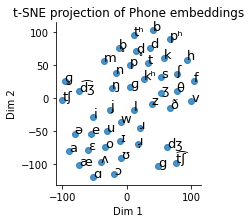

In [40]:
# TSNE
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
lang_code="eng"
lang_id=locale_to_id[lang_code]
# phones_to_choose=["k","p","tʰ","pʰ","s","ɪ","m","b","t","s","a","e","i","o",
                 # "n","ŋ","ɭ","θ","f"]
# phones_ids=[lang_to_phone_to_ids[lang_code][i] for i in phones_to_choose]
phones_ids=list(range(2,49))
phones_to_choose=[lang_to_ids_to_phone[lang_code][i] for i in phones_ids]
data_1000 = model.attr_embeds(lang_to_phoneId_to_attrib_array[lang_id][phones_ids]).detach().cpu().numpy()
# labels_1000 = [lang_to_ids_to_phone[lang_code][i] for i in range(len(lang_to_ids_to_phone[lang_code]))]
labels_1000 = phones_to_choose

model_tsne = TSNE(n_components = 2, random_state = 0)
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000

tsne_data = model_tsne.fit_transform(data_1000)

# creating a new data frame which
# help us in plotting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data = tsne_data,
	columns =("Dim_1", "Dim_2", "label"))
tsne_df.Dim_1=pd.to_numeric(tsne_df.Dim_1)
tsne_df.Dim_2=pd.to_numeric(tsne_df.Dim_2)
# tsne_df.Dim_2=tsne_df.Dim_2.to_numeric()

# fig, ax = plt.subplots(1)
# sn.scatterplot(x='Dim_1', y='Dim_2', hue='label', data=tsne_df, ax=ax,s=120, legend=phones_to_choose)
# lim = (tsne_data.min()-50, tsne_data.max()+50)
# ax.set_xlim(lim)
# ax.set_ylim(lim)
# ax.set_aspect('equal')
# # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
# ax.legend()

ax = sn.lmplot('Dim_1', # Horizontal axis
           'Dim_2', # Vertical axis
           data=tsne_df, # Data source
           fit_reg=False, # Don't fix a regression line
           size = 3,
           aspect =1) # size and dimension

plt.title('t-SNE projection of Phone embeddings')
# Set x-axis label
plt.xlabel('Dim 1')
# Set y-axis label
plt.ylabel('Dim 2')


def label_point(ax):
    for i, point in tsne_df.iterrows():
        # print(type(point['x']))
        ax.text(point['Dim_1']+.02, point['Dim_2'], str(point['label']),size=13)

label_point(plt.gca())  


In [101]:
model.allosaurus_layer_matrix[0]

Parameter containing:
tensor([[ 9.9985e-01, -1.0000e-08, -9.9841e-09,  ..., -1.0019e-08,
          1.6943e-03, -1.0000e-08],
        [-9.9991e-09,  1.0013e+00,  1.4200e-04,  ..., -1.0001e-08,
         -9.9991e-09, -9.9998e-09],
        [-9.9991e-09, -1.0003e-08,  1.0029e+00,  ..., -9.9991e-09,
         -9.9991e-09, -9.9991e-09],
        ...,
        [-9.9991e-09,  5.8687e-06, -1.0073e-09,  ..., -1.0085e-08,
         -1.0001e-08, -1.1462e-08],
        [-9.9991e-09, -1.0011e-08, -1.5448e-05,  ..., -3.5731e-04,
          1.6974e-03, -1.7604e-04],
        [-9.9991e-09, -9.5259e-06,  1.0069e-03,  ..., -9.9991e-09,
         -9.9991e-09, -9.9991e-09]], device='cuda:0', requires_grad=True)

In [177]:
x=model.phone_distribution_transf_matrix.weight.detach()
(x@x.T)ctc_loss

SyntaxError: invalid syntax (1642992257.py, line 2)

In [75]:
# torch.nn.functional.log_softmax(
torch.amax(scores[-10],dim=-1)

tensor([[6.2980e+00, 6.5567e-01, 0.0000e+00,  ..., 1.1314e-03, 0.0000e+00,
         0.0000e+00],
        [6.2886e+00, 6.5413e-01, 0.0000e+00,  ..., 1.6784e-03, 0.0000e+00,
         0.0000e+00],
        [6.2717e+00, 6.5207e-01, 0.0000e+00,  ..., 2.1031e-03, 0.0000e+00,
         0.0000e+00],
        ...,
        [6.3358e+00, 6.6066e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3370e+00, 6.6051e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.3361e+00, 6.5987e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])

In [ ]:
model.allosaurus_layer_matrix.keys()

In [45]:
import editdistance
editdistance.eval('banana', 'nbn')


4

In [ ]:
a=torch.nn.Parameter(torch.zeros(3,3))
torch.linalg.matrix_norm(a-a+1)

In [ ]:

set(mozilla_dataset_train.lang)

In [ ]:
signature_matrix